# Battle of the Neighborhoods
## Model_binary

__Table of Contents__

* [Train-test split](#Train-test-split)
* [Output labels](#Output-labels)
* [Feature-selection](#Feature-selection)
* [Logistic regression](#Logistic-regression)
* [Summary](#Summary)

![](https://vignette.wikia.nocookie.net/phineasandferb/images/9/9b/Treehouse_Fight.jpg/revision/latest?cb=20090320212850)

# For a __Brand New Sports Facility__ in Hyderabad, India


__The story so far...__

In the notebook 'intro_data.ipynb', the [motivation](intro_data.ipynb#Introduction) for building a sports facility was outlined. [Data](intro_data.ipynb#Data) was also collected using Google Place API, and stored in JSON files. This data was collected for ten venue categories:
[Sports facilities, cinemas, pubs, gyms, banks, hospitals, supermarkets, schools, colleges, and restaurants](intro_data.ipynb#Points-of-interest-in-Hyderabad).

In 'preprocessing.ipynb', a large dataset of locations was built. The locations of existing sports facilities was supplemented with locations chosen randomly (uniformly) from the city. For all of these locations, the distances to ten nearest venues for each of the ten venue categories was calculated. This distance data was cast to a pandas DataFrame and subsequently stored to disk to the file 'fullDataset.json'.


__In this notebook...__

We simple logistic regression. We experiment with feature selection and output labels to find the most appropriate choice. Finally, we interpret the coefficients (for logistic regression at least) to gain insight into the locational dependence of sports venues on other categories.

Spoiler alert! Logistic regression, the way I implement it here, feels a bit unsatisfactory. By design, we have a lot more unsuitable locations than suitable locations in the dataset. Labelling them with two classes introduces very significant class imbalance. This makes things a bit messy. Ultimately, while the model does manage to classify locations reasonably well, it leaves a bitter aftertaste. 


__In the next notebook...__

We discard the binary class labels, and keep suitability scores as the target - a real number between 0 and 1. For the continuous target, we first use linear regression and see how it goes. One issue with simple linear regression is that the output may not be neatly bounded by 0 and 1. To fix this, we take the easy route and just throw a feedforward neural network at it with a sigmoid activation at output. We'll try single and multilayer networks. Hopefully, one of these models would do a good job. 


In [1]:
import json
import numpy as np
import pandas as pd
import time # Will use sleep from time to pause 
import matplotlib.pyplot as plt
import folium

from warnings import warn
%matplotlib inline

In [2]:
df_full = pd.read_json('fullDataset.json')

venueCats = ["sports", "cinemas", "pubs", "gyms", "banks", 
             "hospitals", "supermarkets", "schools", "colleges", "restaurants"]
venueCats = sorted(venueCats, key=str.lower)

# Because we consider distances to other venues when defining features
# and distance to sports facilities when defining output labels and scores
venueCats_sans_sports = venueCats.copy()
venueCats_sans_sports.remove('sports')

# Location of the center of the city: 
# The location of the "Buddha Statue" in a lake called "Hussain Sagar" at the center of the city is used
latCC = lat_CC = 17.415435
lngCC = lng_CC = 78.474296

df_full.reset_index(drop=True, inplace=True)

print(venueCats)
print(df_full.columns[3:].values)

['banks', 'cinemas', 'colleges', 'gyms', 'hospitals', 'pubs', 'restaurants', 'schools', 'sports', 'supermarkets']
['banks' 'cinemas' 'colleges' 'gyms' 'hospitals' 'pubs' 'restaurants'
 'schools' 'sports' 'supermarkets']


In [3]:
df_full.head()

,Location,Latitude,Longitude,banks,cinemas,colleges,gyms,hospitals,pubs,restaurants,schools,sports,supermarkets
0,"[17.5333915503, 78.3019480094]",17.533392,78.301948,"[0.5944527837, 0.9123336302, 1.1945137594, 1.2...","[2.5226926821999998, 2.7441248317999998, 3.292...","[2.2231445958, 2.4326837456, 2.5586923999, 2.6...","[0.4141267293, 0.6469971331000001, 1.470688927...","[2.4209027735, 2.6356289195000002, 2.651096537...","[0.4326443585, 2.0161228142, 2.0193793055, 2.0...","[2.8365380395, 2.8365380395, 3.6162430067, 4.7...","[0.3709854836, 0.5719475071, 0.5819651468, 0.6...","[0.9887859477000001, 1.5864883539, 1.615919187...","[1.5239640962, 2.0930682862, 2.4115800549, 2.6..."
1,"[17.4942544, 78.1426446]",17.494254,78.142645,"[0.6754174845, 0.6909662965000001, 0.746231804...","[4.2429786787, 4.5061204992, 7.7483776384, 8.4...","[0.1316769686, 1.8442535139, 3.9067855433, 3.9...","[0.14670746310000002, 1.0841352373, 1.67283942...","[3.8287129508, 4.5275674007, 4.5310875347, 4.5...","[4.5335069359, 4.7413597513, 8.7463913996, 8.9...","[10.3520028636, 16.9519428463, 16.9519428463, ...","[0.5237399309, 0.5316808758, 0.924419337700000...","[0.0, 0.018022444000000002, 0.0319378584, 0.96...","[13.9095550906, 13.9142012707, 14.3331331326, ..."
2,"[17.2736776385, 78.5670567671]",17.273678,78.567057,"[2.2614932277, 2.2624956284, 2.2690632559, 2.2...","[6.4672878001, 6.9237351057000005, 6.956319766...","[1.2465647364, 1.7114100722, 1.9511505964, 2.0...","[1.9511606865000002, 2.1844757094, 2.228745610...","[5.5789316488, 6.0012584187, 6.064016701, 6.44...","[1.2535245812, 3.3873357157, 3.7890114492, 5.2...","[6.7748896167, 7.4194043843, 7.4250739684, 7.4...","[0.9387879407, 1.1159395825, 1.1597221395, 1.2...","[1.6722465827000002, 2.8126944449, 2.976785561...","[2.2234366467, 5.2608094770000005, 5.279426647..."
3,"[17.2159971208, 78.5018378083]",17.215997,78.501838,"[1.0231317789, 1.0290610733, 1.552344901600000...","[2.8466319478, 7.118468551, 11.137838919, 11.4...","[2.667688001, 2.7771837433, 2.8335145658, 2.84...","[0.8044426591, 0.9004906079, 2.6654642685, 2.7...","[11.6441161148, 11.821180716, 12.5591125675, 1...","[5.8143442376, 7.8437278947, 7.905480393599999...","[3.6821682024999998, 7.8654203973, 7.942906800...","[0.9962343093, 1.0744389745, 1.902801744, 2.60...","[0.6524729677000001, 2.9911387450999998, 4.248...","[4.7284731381, 10.1528607584, 11.1395369905, 1..."
4,"[17.5405338, 78.3857611]",17.540534,78.385761,"[0.17909229840000002, 0.773952089, 1.214674442...","[4.1980559378, 4.278676515, 4.278676515, 4.480...","[0.17714835180000002, 0.2923846075, 0.76939061...","[0.9023824009, 1.5523972775, 1.5571471251, 2.0...","[2.720175495, 4.302153125, 4.3027458242, 4.588...","[2.2791124241, 3.0928239586, 3.8176102177, 3.8...","[2.2898091591, 3.0622868938, 3.2388035882, 4.5...","[0.0762680701, 0.28190401390000003, 0.36464936...","[0.0, 0.0231518678, 0.0493814418, 0.0514730139...","[2.2811736948, 2.2908107154, 2.2976849177, 2.3..."


In [4]:
n_nbrs = len(df_full.iloc[0,5])  
print("Using n_nbrs:",n_nbrs)

Using n_nbrs: 10


# Train-test split

Let's use 10% for testing. 10% puts the number of testing datapoints at 800, which is a decent number of points.

In [5]:
from sklearn.model_selection import train_test_split
test_size = 0.1

df_train, df_test = train_test_split(df_full, test_size=test_size,random_state=0)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
print(len(df_train), len(df_test))
# Check to make sure that these are pandas dataframes
df_train.head()

7227 803


,Location,Latitude,Longitude,banks,cinemas,colleges,gyms,hospitals,pubs,restaurants,schools,sports,supermarkets
0,"[17.5261463694, 78.6276052594]",17.526146,78.627605,"[1.1910578882, 2.3531500648, 2.8422613385, 3.7...","[3.8080600188, 3.880950221, 4.6192567462, 4.61...","[0.7143162385, 0.7161157994, 0.720318063800000...","[1.6406338103, 3.8926011936, 4.2390121412, 4.3...","[2.285952825, 6.0126362675, 6.6448280745, 7.92...","[1.3274757278, 4.7781594108, 4.9757089922, 4.9...","[7.0065596931, 8.6121227002, 8.6704252244, 8.7...","[0.8682600604, 1.4718778649, 1.502702441, 1.86...","[0.7575276609, 0.8078827149000001, 0.808729543...","[4.4526784487, 4.4526784487, 4.6963936487, 4.6..."
1,"[17.4896164664, 78.5875253239]",17.489616,78.587525,"[0.5046672785, 0.9959750281, 1.098482708, 1.10...","[1.3856085387000001, 1.3856085387000001, 2.075...","[1.1456593896, 1.2360172398, 1.2691097698, 1.3...","[0.5583676247, 1.0898644747, 1.0938081437, 1.2...","[1.1833596464, 2.3888138403, 2.4049978613, 2.4...","[0.7666721712, 1.0510152815, 1.266574856600000...","[1.186694115, 2.7852363335, 3.4320192253, 3.43...","[0.4309211354, 0.5527315308, 0.5540815468, 0.6...","[0.191959, 0.9968841887000001, 1.3476322072, 1...","[0.6596358787000001, 1.1862386071, 1.190026921..."
2,"[17.4584430135, 78.3858941153]",17.458443,78.385894,"[0.6614147295, 0.9183693181, 0.9243992465, 0.9...","[0.1226588088, 0.6658709516, 0.978313008900000...","[0.2378676964, 0.40345462060000004, 0.76360035...","[0.23238174390000002, 0.6549283723, 0.92749517...","[0.9857354936, 1.4575890019, 1.5033332981, 2.0...","[0.5772582883, 0.8007587541000001, 0.858765659...","[1.0950257596, 1.0974015758, 1.1524645376, 1.3...","[1.1475787796999999, 1.1587734907, 1.188857435...","[0.23238174390000002, 0.2351670223, 0.34204898...","[1.3389279973, 1.3730875276, 1.486202633, 1.61..."
3,"[17.2098955955, 78.2551144749]",17.209896,78.255114,"[4.6863408451, 5.142751971, 5.7310288261, 6.08...","[15.093369544, 15.3850924384, 15.4836151877, 1...","[4.8113402658, 7.3866685385, 7.9082040042, 7.9...","[7.1227889439, 7.4131857985, 7.7316160541, 8.5...","[7.7238078534, 7.7447642134, 7.9383691764, 8.1...","[8.5401378411, 10.7018630694, 14.3107583072, 1...","[14.7280597754, 15.012382467, 15.0239117883, 1...","[1.8165287912, 2.1198085173, 2.6493099229, 2.9...","[7.1532318737, 7.9480794796000005, 9.214021691...","[6.1061942507, 15.2640151772, 15.8625349948, 1..."
4,"[17.5933735913, 78.6461721681]",17.593374,78.646172,"[3.0000181358, 3.7973513772, 3.9957430046, 3.9...","[5.2367769465, 6.7092104902, 7.9029192477, 7.9...","[0.5844938355, 3.140211194, 3.3731424611, 3.43...","[7.9440239155, 8.013034184, 8.0202853444, 9.00...","[5.4448750133, 10.6512842024, 13.5323509883, 1...","[4.9253467588, 6.4018387935, 8.1228470829, 9.6...","[14.292169597000001, 15.5484860745, 15.6553784...","[3.4885486375, 3.5265950575, 3.9895825396, 4.1...","[3.8898353197, 3.8958615290000003, 8.255870867...","[9.3766983373, 9.3797909069, 9.3935589528, 11...."


Right now, these dataframes just have distances. They do not contain features and output labels. We will experiment with features on labels on df_train (using k-fold cross validation). Features and labels will be defined for df_test only at the end.

In [6]:
df = df_train # Make things easier.

df.loc[:,venueCats] = df.loc[:,venueCats].applymap(lambda x: np.array(x))

df.head()

C:\Users\Sabarish\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Location,Latitude,Longitude,banks,cinemas,colleges,gyms,hospitals,pubs,restaurants,schools,sports,supermarkets
0,"[17.5261463694, 78.6276052594]",17.526146,78.627605,"[1.1910578882, 2.3531500648, 2.8422613385, 3.7...","[3.8080600188, 3.880950221, 4.6192567462, 4.61...","[0.7143162385, 0.7161157994, 0.720318063800000...","[1.6406338103, 3.8926011936, 4.2390121412, 4.3...","[2.285952825, 6.0126362675, 6.6448280745, 7.92...","[1.3274757278, 4.7781594108, 4.9757089922, 4.9...","[7.0065596931, 8.6121227002, 8.6704252244, 8.7...","[0.8682600604, 1.4718778649, 1.502702441, 1.86...","[0.7575276609, 0.8078827149000001, 0.808729543...","[4.4526784487, 4.4526784487, 4.6963936487, 4.6..."
1,"[17.4896164664, 78.5875253239]",17.489616,78.587525,"[0.5046672785, 0.9959750281, 1.098482708, 1.10...","[1.3856085387000001, 1.3856085387000001, 2.075...","[1.1456593896, 1.2360172398, 1.2691097698, 1.3...","[0.5583676247, 1.0898644747, 1.0938081437, 1.2...","[1.1833596464, 2.3888138403, 2.4049978613, 2.4...","[0.7666721712, 1.0510152815, 1.266574856600000...","[1.186694115, 2.7852363335, 3.4320192253, 3.43...","[0.4309211354, 0.5527315308, 0.5540815468, 0.6...","[0.191959, 0.9968841887000001, 1.3476322072, 1...","[0.6596358787000001, 1.1862386071, 1.190026921..."
2,"[17.4584430135, 78.3858941153]",17.458443,78.385894,"[0.6614147295, 0.9183693181, 0.9243992465, 0.9...","[0.1226588088, 0.6658709516, 0.978313008900000...","[0.2378676964, 0.40345462060000004, 0.76360035...","[0.23238174390000002, 0.6549283723, 0.92749517...","[0.9857354936, 1.4575890019, 1.5033332981, 2.0...","[0.5772582883, 0.8007587541000001, 0.858765659...","[1.0950257596, 1.0974015758, 1.1524645376, 1.3...","[1.1475787796999999, 1.1587734907, 1.188857435...","[0.23238174390000002, 0.2351670223, 0.34204898...","[1.3389279973, 1.3730875276, 1.486202633, 1.61..."
3,"[17.2098955955, 78.2551144749]",17.209896,78.255114,"[4.6863408451, 5.142751971, 5.7310288261, 6.08...","[15.093369544, 15.3850924384, 15.4836151877, 1...","[4.8113402658, 7.3866685385, 7.9082040042, 7.9...","[7.1227889439, 7.4131857985, 7.7316160541, 8.5...","[7.7238078534, 7.7447642134, 7.9383691764, 8.1...","[8.5401378411, 10.7018630694, 14.3107583072, 1...","[14.7280597754, 15.012382467, 15.0239117883, 1...","[1.8165287912, 2.1198085173, 2.6493099229, 2.9...","[7.1532318737, 7.9480794796000005, 9.214021691...","[6.1061942507, 15.2640151772, 15.8625349948, 1..."
4,"[17.5933735913, 78.6461721681]",17.593374,78.646172,"[3.0000181358, 3.7973513772, 3.9957430046, 3.9...","[5.2367769465, 6.7092104902, 7.9029192477, 7.9...","[0.5844938355, 3.140211194, 3.3731424611, 3.43...","[7.9440239155, 8.013034184, 8.0202853444, 9.00...","[5.4448750133, 10.6512842024, 13.5323509883, 1...","[4.9253467588, 6.4018387935, 8.1228470829, 9.6...","[14.292169597000001, 15.5484860745, 15.6553784...","[3.4885486375, 3.5265950575, 3.9895825396, 4.1...","[3.8898353197, 3.8958615290000003, 8.255870867...","[9.3766983373, 9.3797909069, 9.3935589528, 11...."


# Feature selection



The premise for the model is that suitability of a location for a sports facility is dependent on its proximity to venues of other categories. This proximity to venues of other categories becomes the input feature vector, $\boldsymbol{x}$. 

In a very hand-wavy way, the features will be some function of distances to nearest 'n' venues of each category. Because it makes sense. This function just be a set/vector containing distances to, say, 5 nearest venues of each category for a specified location. Or some weighted sum of distances to 5 nearest venues of each category. Or the distance to the 3rd closest venue of each category. Or something along these lines. The point is, for any location in the city, we must have a method to call its 'n' nearest venues of each category. These nearest venues can then call a second method to produce the features vector. 

$~$

#### Excluding existing sports venues from feature vectors

__We will not use distance/proximity to existing sports venues as a feature.__ I admit that it makes a lot of sense to include the distance to existing venues. After all, building a new facility right next to an existing one may not make a lot of business sense. The problem is that this could introduce a lot of unnecessary complexity. Some sports facilities host just one sport, while others are complexes containing a lot of sports halls. Some of these complexes have a single location ID on Google Places, while others have multiple. Some venues are tagged twice or thrice on Google Places. 

The output label, as we see later, will have something to do with distance to the nearest sports facility. Having a feature and the output label contain the same information introduces some ambiguity. Without being too tedious about this, I will just drop this piece of information from feature vectors. 


#### Proximity

We have data on the 10 closest venues for any specified (latitude,longitude) in Hyderabad. Next, on to defining features.

Well, except for one tiny thing. I want to use proximity as the metric instead of distance. How do I define proximity? Easy...
$$ \frac{1}{1+ distance} $$
When distance is 0, proximity is 1. For infinite distance, proximity is 0. Simple enough. 

Why am I doing this? It makes more sense to me. And I don't like seeing lots of negative coefficients in my regression models. 

Actually, I'll change this just a little bit to
$$ \frac{1}{1 + (distance/0.5)} .$$
The factor (1/0.5) for distance is included because 0.5km "feels" like a better scaling factor for sizes of neighborhoods than 1km. 

Later, we use proximity=0.5 as a threshold to decide if a location is suitable or not. Since we use existing sports facilities to set $S=1$, this means that any location within a 0.5km radius of an existing facility is also a suitable location. 0.5km is about a 5 minute walk. This scaling makes sense.

__Note: I tried making this definition a bit more flexible by introducing an exponent for (distance/0.5). That made things more complicated without producing a noticeable benefit.__

In [7]:
proximityFun = lambda dist : (1.)/(1.+(dist/0.5))

We will define four types of features:
1. Distance to $n^{th}$ closest venue for each category (excluding sports)
2. Distance to first $n$ closest venues for each category (excluding sports)
3. Proximity to $n^{th}$ closest venue for each category (excluding sports)
4. Proximity to first $n$ closest venues for each category (excluding sports)

In [50]:
# First, define a function that takes venue category and location as input,
#    and returns an associated feature (scalar or vector)
# Then, we build a class of such functions

def dist_n(dfTmp, venueCat, n=2):
    """ Returns distance to (n+1)^th closest venue of category venueCat for all locations in dfTmp. n Defaults to 2.
    n can take values 0 to n_nbrs-1 (inclusive). """
    return dfTmp[venueCat].apply(lambda x: x[n]).to_numpy().reshape((-1,1))

def prox_n(dfTmp, venueCat, n=2):
    """ Returns proximity to (n+1)^th closest venue of category venueCat for all locations in dfTmp. 
    n defaults to 2. 
    n can take values 0 to n_nbrs-1 (inclusive) """
    return dfTmp[venueCat].apply(lambda x: proximityFun(x[n]) ).to_numpy().reshape((-1,1))

def dist_0_n(dfTmp, venueCat, n=2):
    """ Returns distance to 1st to (n+1)^th closest venue of category venueCat for all locations in dfTmp. n Defaults to 2.
    n can take values 0 to n_nbrs-1 (inclusive). """
    n = min(n,n_nbrs-1)
    return np.array(dfTmp[venueCat].apply(lambda x: x[:n+1] ).to_list()).reshape((-1,n+1))
    

def prox_0_n(dfTmp, venueCat, n=2):
    """ Returns proximity to 1st to (n+1)^th closest venue of category venueCat for all locations in dfTmp. 
    n defaults to 2. 
    n can take values 0 to n_nbrs-1 (inclusive) """
    n = min(n,n_nbrs-1)
    return np.array(dfTmp[venueCat].apply(lambda x: proximityFun(np.array(x[:n+1]) ) ).to_list()).reshape((-1,n+1))


def featureVector(dfTmp,featureFun=prox_n, **kwargs):
    """ Returns vector containing features associated to a location 
    Positional arguments:
        lat : Latitude
        lng : Longitude
    Keyword arguments:
        featureFun : Callable that takes arguments (venueCat, **kwargs) to define features
                        Defaults to feature_prox_n                    
        **kwargs : Passed directly to featureFun
    
    Returns:
        featureVec : pd.Series of shape (m*N,), where m is number of floats returned by featureFun,
                        N is len(venueCats)-1
    """
    assert venueCats_sans_sports == sorted(venueCats_sans_sports, key=str.lower)  
    # Ensure venueCats_sans_sports properly ordered
    
       
    featureArr0 = featureFun(dfTmp,venueCats_sans_sports[0], **kwargs) # Features for category 0
    assert isinstance(featureArr0, np.ndarray) and featureArr0.ndim == 2
    m = featureArr0.shape[1]
    featureArr = np.zeros( (len(dfTmp), m * (len(venueCats_sans_sports)) ) )  # Initialize array for all cats,except sports
    featureArr[:,:m] = featureArr0 # Assign features for cat 0
    
    # Assign features for other categories
    for index in range(1, len(venueCats_sans_sports)):
        featureArr[:,index * m : (index+1) * m ] = featureFun(dfTmp,
                                venueCats_sans_sports[index], **kwargs)
    
    return featureArr

In [9]:
venueCat = "banks"
np.set_printoptions(precision=4)

print("Proximity of {} closest {} to ({},{}):".format(n_nbrs,venueCat, df.iloc[0,1], df.iloc[0,2]))
print( prox_0_n(df,venueCat,n=n_nbrs) )
print("Distance of {} closest {} to ({},{}):".format(n_nbrs,venueCat, df.iloc[0,1], df.iloc[0,2]))
print( dist_0_n(df,venueCat,n=n_nbrs) )


Proximity of 10 closest banks to (17.5261463694,78.6276052594):
[[0.2957 0.1752 0.1496 ... 0.1055 0.1049 0.0995]
 [0.4977 0.3342 0.3128 ... 0.3028 0.2975 0.2955]
 [0.4305 0.3525 0.351  ... 0.2817 0.2766 0.274 ]
 ...
 [0.36   0.1237 0.1086 ... 0.0965 0.0956 0.0916]
 [0.244  0.2435 0.2359 ... 0.1531 0.1523 0.1516]
 [0.171  0.1102 0.1089 ... 0.1036 0.1032 0.1031]]
Distance of 10 closest banks to (17.5261463694,78.6276052594):
[[1.1911 2.3532 2.8423 ... 4.2403 4.2653 4.5253]
 [0.5047 0.996  1.0985 ... 1.1514 1.1804 1.1918]
 [0.6614 0.9184 0.9244 ... 1.2748 1.3078 1.325 ]
 ...
 [0.8889 3.5411 4.1043 ... 4.6824 4.7276 4.9604]
 [1.5491 1.5536 1.6192 ... 2.7658 2.7831 2.799 ]
 [2.4236 4.0371 4.0904 ... 4.3278 4.3461 4.3495]]


In [10]:
print("Proximity to 3 closest venues...")
n=3-1

print();print("using l=1. in proximity definition")
print(featureVector(df, featureFun=prox_0_n, n=n).reshape(-1,3).T)


Proximity to 3 closest venues...

using l=1. in proximity definition
[[0.2957 0.1161 0.4118 ... 0.0434 0.2789 0.0754]
 [0.1752 0.1141 0.4111 ... 0.0427 0.2732 0.0522]
 [0.1496 0.0977 0.4097 ... 0.0427 0.2394 0.0423]]


We now have a simple function to create input feature vectors. The function allows adequate flexibility in terms of the definition of features. Next, the output labels...

## Output labels

The output label is the suitability score. We will use the proximity of the closest sports venue as the suitability score; the rationale for this is explained a few cells below. Remember that there is a parameter 'l' in the definition of the proximity. Large values of 'l' produce greater spread in suitability scores. 

In [11]:
def labelArr(dfTmp):
    return prox_n(dfTmp, 'sports',n=0).flatten()

labelArr(df)

array([0.3976, 0.7226, 0.6827, ..., 0.1347, 0.2732, 0.3325])

# Training a model

The output label is the suitability score. I have argued that the fact that existing facilities are located where they are establishes that their locations are suitable. Thus, locations of existing facilities must have a suitability score of 1 (the scale goes from 0 to 1, in line with probability scores of a typical logistic classifier). 

We must find the functional dependence, given by $f$, 
$$ f(\boldsymbol{x}) = S, $$
where $\boldsymbol{x}$ is the input feature vector, and $S$ is the suitability score. 

This function $f$ is where the machine learning model comes into the picture. Training data is used to create a model that emulates $f$. 

#### The challenge

__The problem is, training data that has locations of only existing sports facilities is inadequate.__ If we train the model using only this data, where all datapoints have an output label of $S=1$, then the most "accurate" model would be one which maps every feature vector to $S=1$. Such a model is useless, for obvious reasons. 

__We need 'negative' training data.__ That is, training data that have suitability scores sufficiently smaller than 1. We assigned $S=1$ using existing facilities. How do we assign $S=0$ to any location and its associated feature vector? If we had a way to do this beforehand, there would be no reason to train a model in the first place. 

$~$


#### In a land far, far away...

Let us suppose that, in some hypothetical city, there are a 1000 sports facilities. Let us further suppose that the locations of these facilities are ideally distributed. Well, almost. There is exactly one location in this hypothetical city, call it NewTown, where a sports facility can be profitably operated. 

Suppose that for any location, existing sports facility or otherwise, we use the proximity to nearest sports facility as the suitability score. This suitability score will be quite appropriate. Because for most locations in the city, it reflects the suitability of such venues. The only locations where the suitability score misrepresents the actual suitability are those around NewTown. NewTown can be a good location to build a new facility, but it ends up being assigned a low suitability score. This can be considered as locations around NewTown being mislabelled. They should have had $S \approx 1$, but ended up with $S \approx 0$ because we used proximity to other sports venues.

When a model is trained for this city, it has a lot of high quality data, and a tiny set of mislabelled data. This model can be expected to do quite well. The large number of high quality datapoints are bound to eclipse the effects of a few mislabelled datapoints. 

$~$

#### Mislabelling in the training data for Hyderabad

In the hypothetical case above, the model is expected to do well when the output label is proximity to the nearest sports facility. Because most locations suitable for such venues were appropriately occupied. This is not the case in Hyderabad. There must be a bunch of locations that are suitable, but are not presently occupied by sports facilities. Let's call such venues HPLs, for High Potential Locations. 

Ideally, HPLs should be tagged with an output label $S \approx 1$. The output labels for the training data are going to be labelled with proximity to the nearest existing sports facility as the suitability score $S$. HPLs will have $S$ significantly less than 1, depending on their distance to the nearest facility. Thus, HPLs are bound to be mislabelled in the training data. Locations close to HPLs will also be subject to this mislabelling. 

The extent of mislabelling in the training data depends on 
1. The distribution of existing sports facilities - we do not know that they are ideally distributed.
2. The number of HPLs in the city. If there are just a handful of these, then the number of mislabelled points would be a lot fewer compared to properly labelled datapoints.

In this project, we just make a note of the limitations of the present approach. We shall not investigate the extent of mislabelling or its consequences. We have also not discussed second order effects: if a few more sports facilities are started, how does this affect the profitability of existing facilities? Does the model trained here still hold? These are questions for a different time and place.



### Cleaning and normalisation

I have mentioned earlier, quite a few times actually, that __I will not be cleaning the data__. The datasets contain some venues that don't belong in the datasets, and some venues that are missing. There could be some bias in this. I will ignore all of this.

Fortunately, __there are no missing values for any of the datapoints__.

__There is no need for normalisation__. All of the features belong to the same class - a distance, or a proximity. Some fancy neural networks may require the data to have zero mean, but we are not going to use such models. For the simple models we shall use, the inherent uniformity in the distributions of the features serves the purpose.

In [12]:
def clamp(x): 
  return max(0, min(x, 255))

def rgb2hex(r,g,b):
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))

def blueRed(x):
    assert 0<= x <= 1
    if x <= 0.5:
        r = int(512*x)
        b = 256
        g = int(512*x)
    else :
        r = 256
        b = int((1.-x)*512)
        g = int((1.-x)*512)
    return rgb2hex(r,g,b)

# Plot first 100 locations in dataset
map_tmp = folium.Map(
    location=[lat_CC, lng_CC], zoom_start=11)

y = labelArr(df)
for ind in range(100):
    folium.CircleMarker(
        [df.iloc[ind,1], df.iloc[ind,2]],
        radius=3,
        fill=True,
        fill_color=blueRed(y[ind]),
        color = blueRed(y[ind]),
        fill_opacity=0.7).add_to(map_tmp)

print("Colormap: blue for S=0, red for S= 1")    
map_tmp

Colormap: blue for S=0, red for S= 1


The dataset we have is labelled such that locations close to city center have large suitability scores (red in the map) and those far away have small suitability scores (blue in the map). There are some datapoints with large suitability scores located away from the city though.

# Logistic regression

We have defined four types of features. Before we run them all, let's do a simple case of logistic regression. For this simple case, we'll use proximity to 3rd nearest venue (n=2). 

We will use L1 penalty (instead of L2) in the hope that some features drop out, at least when we use lots of features later. L2 is supposedly better behaved, but for the small number of features we use, this may not be a significant issue.

In [13]:
X = featureVector(df, featureFun=prox_n, n=2)
y = prox_n(df, 'sports', n=0)
yBool = (y>=0.5).astype(int)
yBool

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [14]:
print("Number of positive datapoints in training set:", np.sum(yBool))
print("Number of negative datapoints in training set:", yBool.size-np.sum(yBool))

Number of positive datapoints in training set: 1339
Number of negative datapoints in training set: 5888


y is supposed to act as a probability score, and yBool contains actual labels. Note that we used 0.5 as the threshold here. Proximity, the way we defined it, becomes 0.5 when the distance is 0.5km. The threshold of 0.5 essentially means that we are assigning any location within a 0.5km radius of an existing facility as being suitable.

The number of negative datapoints is significantly greater than the number of positive datapoints. This is by design. We have a lot of datapoints obtained by random sampling. Most of these should not fall into suitable locations. This class imbalance is something we have to deal with. We'll let scikit-learn impose class weights to do the balancing for us.

Coefficients from logistic regression:
banks        :  1.0406
cinemas      : -1.8353
colleges     :  4.4077
gyms         :  2.7181
hospitals    : -1.1459
pubs         :  0.7910
restaurants  :  3.3674
schools      :  0.0715
supermarkets :  4.2064

Number of actual positives in testing set: 163
Number of actual negatives in testing set: 640
Accuracy of majority classifier:
0.797011207970112

Jaccard similarity score:
0.813200498132005

Log loss:
0.462723184430015

f1 score:
0.6445497630331753

Confusion matrix:
[[517 123]
 [ 27 136]]

Average precision:
0.11964071017054116


C:\Users\Sabarish\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Consider writing a helper function to calculate p-values
  del sys.path[0]


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.12')

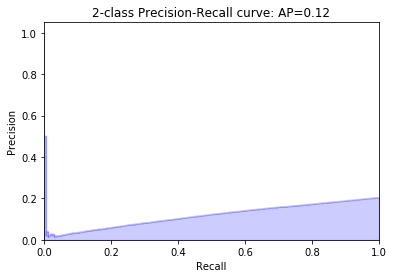

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score, jaccard_similarity_score
from sklearn.utils.fixes import signature

# Split venues into suitable and unsuitable, right down the middle. Weight classes so they're balanced.
logisticModel = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced').fit(X, yBool.flatten()) 

print("Coefficients from logistic regression:")
for ind in range(len(venueCats_sans_sports)):
    print("{:13s}: {:7.4f}".format(venueCats_sans_sports[ind], logisticModel.coef_[0][ind]))
    
warn("Consider writing a helper function to calculate p-values")

# Testing
X_test = featureVector(df_test, featureFun=prox_n, n=2)
y_test = prox_n(df_test, 'sports', n=0).flatten()
yBool_test = (y_test>=0.5).astype(int).flatten()

predictions = logisticModel.predict(X_test)
prob_predictions = logisticModel.predict_proba(X_test)

nPos = np.sum(yBool_test)
nNeg = yBool_test.size - nPos
print()
print("Number of actual positives in testing set:", nPos)
print("Number of actual negatives in testing set:", nNeg)
print("Accuracy of majority classifier:")
print(max(nPos,nNeg)/yBool_test.size)


print()
print("Jaccard similarity score:")
print(jaccard_similarity_score(yBool_test, predictions))

print()
print("Log loss:")
print(log_loss(yBool_test, prob_predictions))

print()
print("f1 score:")
print(f1_score(yBool_test, predictions))

print()
print("Confusion matrix:")
print(confusion_matrix(yBool_test, predictions))

print()
print("Average precision:")
average_precision = average_precision_score(yBool_test, prob_predictions[:,0])
print(average_precision)


precision, recall, _ = precision_recall_curve(yBool_test, prob_predictions[:,0])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

This simple model seems to do fairly well. 

81% Jaccard similarity score as opposed to 80% for majority classifier. Well, what do we expect for data that is so imbalanced?

The f1 score is 64%. We haven't decided on the relative costs of false negatives and false positives. Either way, 64% for this simple model isn't bad. 

The confusion matrix looks good as well. For the minority class (suitable locations), most of the identified locations are suitable indeed. 

The average precision score and precision-recall curve don't look so good. That doesn't necessarily mean the model is useless. These metrics describe the model's behavior with varying threshold for classification. For the typical classifier, these numbers indeed look bad. The present classifier is a bit unusual though - the labels that we have used are a bit dodgy. The labels themselves are dependent on thresholding the proximity to nearest sports facility. It's best not to pay too much attention to these metrics.

We built the previous model using proximitiy to 3rd closest venues. Why 3rd? Well, let's find out which set of features do the best job. 

Let us think of 4 different sets of models for simple logistic regression with linear features:
1. Using proximity to $n^{th}$ nearest venue
2. Using proximity for first to $n^{th}$ nearest venues
3. Using distance to $n^{th}$ nearest venue
4. Using distance for first to $n^{th}$ nearest venues

The function that chooses these features (and the parameters l and n that go into it) is considered a hyperparameter for the logistic regression model.

How do we optimize the hyperparameter(s)? Use k-fold cross validation. Let's use k=5, because, reasons. 


In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from tqdm import tqdm

cv = 5 # Number of folds for k-fold cross validation
thres = 0.5  # Threshold to use for classification
nArr = np.arange(n_nbrs)
featFunList = [dist_n, dist_0_n, prox_n, prox_0_n]

cvalScoreArr_acc = np.zeros((len(featFunList)+1, nArr.size, cv))
cvalScoreArr_f1 = np.zeros((len(featFunList)+1, nArr.size, cv))


logisticModel_untrained = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced')
for i0 in tqdm(range(len(featFunList))):
    featFun = featFunList[i0]
    for i1 in range(nArr.size):
        n = nArr[i1]
    
        X = featureVector(df_train, featureFun=featFun, n=n)
        y = labelArr(df_train)
        yBool = (y>=thres).astype(int)
        # Label is always for closest sports facility, l could vary
        cvalScore_acc = cross_val_score(logisticModel_untrained, X, yBool, cv=cv, scoring='accuracy') # Use accuracy
        cvalScoreArr_acc[i0,i1] = cvalScore_acc
        cvalScore_f1 = cross_val_score(logisticModel_untrained, X, yBool, cv=cv, scoring='f1') # Use f1_score
        cvalScoreArr_f1[i0,i1] = cvalScore_f1



100%|██████████| 4/4 [08:07<00:00, 80.76s/it] 


In [18]:
# Define majority classifier for comparison
majClass = DummyClassifier(strategy='most_frequent')
X = featureVector(df_train, featureFun=dist_n, n=n) # Doesn't matter for majority classifier
y = labelArr(df_train)
yBool = (y>=thres).astype(int)
# Label is always for closest sports facility, l could vary
cvalScore_majClass = np.mean( cross_val_score(majClass, X, yBool, cv=cv, scoring='accuracy') ) # Use f1_score


In [20]:
featFunListStr = ['dist_n', 'dist_0_n', 'prox_n', 'prox_0_n']

print("Average accuracy for majority class: {:4.3f}".format(cvalScore_majClass))

meanScores = np.mean(cvalScoreArr_acc,axis=-1)
print()
print("Average cross validation scores (accuracy)...")
print("     {:8s} | {:8s} | {:8s} | {:8s} ".format(*tuple(featFunListStr)) )
print("              |          |          |          ")
for i1 in range(nArr.size):
    printStr = "n={:2d}:".format(nArr[i1]) + \
            "  {:4.3f}  |".format(meanScores[0,i1]) + \
            "  {:4.3f}   |".format(meanScores[1,i1]) + \
            "  {:4.3f}   |".format(meanScores[2,i1]) + \
            "  {:4.3f}".format(meanScores[3,i1])
            
    print(printStr)

meanScores = np.mean(cvalScoreArr_f1,axis=-1)
print()
print("Average cross validation scores (f1)...")
print("     {:8s} | {:8s} | {:8s} | {:8s} ".format(*tuple(featFunListStr)) )
print("              |          |          |          ")
for i1 in range(nArr.size):
    printStr = "n={:2d}:".format(nArr[i1]) + \
            "  {:4.3f}  |".format(meanScores[0,i1]) + \
            "  {:4.3f}   |".format(meanScores[1,i1]) + \
            "  {:4.3f}   |".format(meanScores[2,i1]) + \
            "  {:4.3f}".format(meanScores[3,i1])
            
    print(printStr)



Average accuracy for majority class: 0.815

Average cross validation scores (accuracy)...
     dist_n   | dist_0_n | prox_n   | prox_0_n 
              |          |          |          
n= 0:  0.760  |  0.760   |  0.817   |  0.817
n= 1:  0.754  |  0.772   |  0.818   |  0.826
n= 2:  0.743  |  0.776   |  0.818   |  0.834
n= 3:  0.757  |  0.780   |  0.819   |  0.835
n= 4:  0.755  |  0.783   |  0.817   |  0.835
n= 5:  0.755  |  0.790   |  0.816   |  0.835
n= 6:  0.756  |  0.794   |  0.816   |  0.833
n= 7:  0.756  |  0.794   |  0.813   |  0.832
n= 8:  0.765  |  0.793   |  0.813   |  0.832
n= 9:  0.764  |  0.795   |  0.811   |  0.832

Average cross validation scores (f1)...
     dist_n   | dist_0_n | prox_n   | prox_0_n 
              |          |          |          
n= 0:  0.579  |  0.579   |  0.625   |  0.625
n= 1:  0.568  |  0.592   |  0.625   |  0.641
n= 2:  0.554  |  0.596   |  0.621   |  0.655
n= 3:  0.564  |  0.599   |  0.620   |  0.656
n= 4:  0.558  |  0.605   |  0.618   |  0.656
n=

Things are a bit messy now. We tried to balance the dataset, but now we have accuracies that aren't better than a majority classifier. This isn't unexpected, but makes it hard to interpret results. The f1 scores aren't too bad, but they don't go together with the accuracy. 

Let's drop datapoints causing the imbalance. We will keep proximity with $l=1$ as the output label, and just drop all of the datapoints in the training set that are neither here nor there - ones with $0.3\leq S <0.5$. Don't worry about the test set for now, because we're doing cross validation. Reduce the lower bound if that's not enough. It should still leave us with about 3000 data points, which isn't too little. 

In [21]:
drop_thres = 0.475 # Start here, and drop in steps of 0.025
y0 = labelArr(df)
nNeg0 = np.sum(y0 <0.5)
nPos0 = np.sum(y0>=0.5)

# Keep looping as long as nNeg doesn't drop below 1.1*nPos0
while True:
    dropInds = np.logical_and( (drop_thres <= y0) , (y0 < 0.5) )
    nDrop =  np.sum(dropInds)
    if (nNeg0-nDrop) <= 1.1*nPos0 :
        break
    else :
        drop_thres -= 0.025

dropInds = dropInds.flatten()
print("Drop entries for {:.3f}<=y<0.5... Number of entries to drop :{}".format(drop_thres, nDrop))

Drop entries for 0.100<=y<0.5... Number of entries to drop :4698


It's not surprising that we have to drop so many entries. Let's use dropInds later whenever needed.

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from tqdm import tqdm

cv = 5 # Number of folds for k-fold cross validation
thres = 0.5  # Threshold to use for classification
nArr = np.arange(n_nbrs)
featFunList = [dist_n, dist_0_n, prox_n, prox_0_n]

cvalScoreArr_acc = np.zeros((len(featFunList)+1, nArr.size, cv))
cvalScoreArr_f1 = np.zeros((len(featFunList)+1, nArr.size, cv))


logisticModel_untrained = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced')
for i0 in range(len(featFunList)):
    featFun = featFunList[i0]
    for i1 in tqdm(range(nArr.size)):
        n = nArr[i1]

        X = featureVector(df_train, featureFun=featFun, n=n)[~dropInds,:]
        y = y0[~dropInds]
        yBool = (y>=thres).astype(int)
        # Label is always for closest sports facility, l could vary
        cvalScore_acc = cross_val_score(logisticModel_untrained, X, yBool, cv=cv, scoring='accuracy') # Use accuracy
        cvalScoreArr_acc[i0,i1] = cvalScore_acc
        cvalScore_f1 = cross_val_score(logisticModel_untrained, X, yBool, cv=cv, scoring='f1') # Use f1_score
        cvalScoreArr_f1[i0,i1] = cvalScore_f1



100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


In [30]:
# Define majority classifier for comparison
majClass = DummyClassifier(strategy='most_frequent')
X = featureVector(df_train, featureFun=dist_n, n=n)[~dropInds,:] # Doesn't matter for majority classifier
y = labelArr(df_train)[~dropInds]
yBool = (y>=thres).astype(int)
# Label is always for closest sports facility, l could vary
cvalScore_majClass = np.mean( cross_val_score(majClass, X, yBool, cv=cv, scoring='accuracy') ) # Use f1_score


In [31]:
featFunListStr = ['dist_n', 'dist_0_n', 'prox_n', 'prox_0_n']

print("Average accuracy for majority class: {:4.3f}".format(cvalScore_majClass))

meanScores = np.mean(cvalScoreArr_acc,axis=-1)
print()
print("Average cross validation scores (accuracy)...")
print("     {:8s} | {:8s} | {:8s} | {:8s} ".format(*tuple(featFunListStr)) )
print("              |          |          |          ")
for i1 in range(nArr.size):
    printStr = "n={:2d}:".format(nArr[i1]) + \
            "  {:4.3f}  |".format(meanScores[0,i1]) + \
            "  {:4.3f}   |".format(meanScores[1,i1]) + \
            "  {:4.3f}   |".format(meanScores[2,i1]) + \
            "  {:4.3f}".format(meanScores[3,i1])
            
    print(printStr)

meanScores = np.mean(cvalScoreArr_f1,axis=-1)
print()
print("Average cross validation scores (f1)...")
print("     {:8s} | {:8s} | {:8s} | {:8s} ".format(*tuple(featFunListStr)) )
print("              |          |          |          ")
for i1 in range(nArr.size):
    printStr = "n={:2d}:".format(nArr[i1]) + \
            "  {:4.3f}  |".format(meanScores[0,i1]) + \
            "  {:4.3f}   |".format(meanScores[1,i1]) + \
            "  {:4.3f}   |".format(meanScores[2,i1]) + \
            "  {:4.3f}".format(meanScores[3,i1])
            
    print(printStr)



Average accuracy for majority class: 0.529

Average cross validation scores (accuracy)...
     dist_n   | dist_0_n | prox_n   | prox_0_n 
              |          |          |          
n= 0:  0.942  |  0.942   |  0.957   |  0.957
n= 1:  0.951  |  0.975   |  0.960   |  0.966
n= 2:  0.959  |  0.980   |  0.959   |  0.970
n= 3:  0.951  |  0.981   |  0.948   |  0.970
n= 4:  0.947  |  0.985   |  0.943   |  0.970
n= 5:  0.947  |  0.988   |  0.938   |  0.970
n= 6:  0.939  |  0.989   |  0.929   |  0.970
n= 7:  0.934  |  0.990   |  0.928   |  0.970
n= 8:  0.947  |  0.991   |  0.927   |  0.971
n= 9:  0.949  |  0.990   |  0.925   |  0.972

Average cross validation scores (f1)...
     dist_n   | dist_0_n | prox_n   | prox_0_n 
              |          |          |          
n= 0:  0.946  |  0.946   |  0.959   |  0.959
n= 1:  0.954  |  0.977   |  0.962   |  0.968
n= 2:  0.961  |  0.981   |  0.961   |  0.971
n= 3:  0.953  |  0.982   |  0.949   |  0.972
n= 4:  0.949  |  0.986   |  0.944   |  0.971
n=

These are some very good numbers indeed. The problem is, this makes it hard to pick out one particular set of features. The accuracy and f1 score are all quite high. 

The best models seem to be the dist_0_n and prox_0_n for n=10. That's 90 features. Making sense of 90 coefficients is a bit tedious. Let's look instead at dist_n and prox_n coefficients for different n.

We don't need cross validation this time. Just a straight-forward model with the full training data, and its associated coefficients.

In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, jaccard_similarity_score, log_loss
from sklearn.dummy import DummyClassifier
from tqdm import tqdm

thres = 0.5  # Threshold to use for classification
nArr = np.arange(n_nbrs)
featFunList = [dist_n, prox_n, dist_0_n, prox_0_n]

# Let's do testing as well
testScoreArr_acc = np.zeros((len(featFunList), nArr.size))
testScoreArr_f1 = np.zeros((len(featFunList), nArr.size))
testScoreArr_ll = np.zeros((len(featFunList), nArr.size))
confuseMatList = []
coeffArr = np.zeros((2,nArr.size, len(venueCats_sans_sports)+1))

funCtr = -1


for featFun in featFunList:
    funCtr += 1
    for i1 in tqdm(range(nArr.size)):
        n = nArr[i1]

        X = featureVector(df_train, featureFun=featFun, n=n)[~dropInds,:]
        y = y0[~dropInds]
        yBool = (y>=thres).astype(int)
        # Label is always for closest sports facility, l could vary
        
        logisticModel = LogisticRegression(penalty='l1',solver='liblinear').fit(X,yBool)
        if funCtr < 2:
            coeffArr[funCtr, i1,0] = logisticModel.intercept_
            coeffArr[funCtr, i1,1:] = logisticModel.coef_.flatten()
        
        X_test = featureVector(df_test, featureFun=featFun, n=n) # Don't drop anything. Use full set
        y_test = labelArr(df_test)
        yBool_test = (y_test>=thres).astype(int)
        
        predictions = logisticModel.predict(X_test)
        prob_predictions = logisticModel.predict_proba(X_test)
        
        testScoreArr_acc[funCtr,i1] = jaccard_similarity_score(yBool_test, predictions)
        testScoreArr_f1[funCtr,i1] = f1_score(yBool_test, predictions)
        testScoreArr_ll[funCtr,i1] = log_loss(yBool_test, prob_predictions)
        confuseMatList.append(confusion_matrix(yBool_test, predictions))
        



100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


In [75]:
print("Coefficients for dist_n:")
coeffNames = ['intercept'] + venueCats_sans_sports
print("     {:12s} | {:12s} | {:12s} | {:12s} | {:12s} | {:12s} | {:12s} | {:12s} | {:12s} | {:12s}".format(
    *coeffNames) )
for i1 in range(nArr.size):
    n=nArr[i1]
    print("n={:2d} {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f}".format(n,
        *tuple(coeffArr[0,i1])) )
    
print();print()
print("Coefficients for prox_n:")
coeffNames = ['intercept'] + venueCats_sans_sports
print("     {:12s} | {:12s} | {:12s} | {:12s} | {:12s} | {:12s} | {:12s} | {:12s} | {:12s} | {:12s}".format(
    *coeffNames) )
for i1 in range(nArr.size):
    n=nArr[i1]
    print("n={:2d} {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f}".format(n,
        *tuple(coeffArr[1,i1])) )

Coefficients for dist_n:
     intercept    | banks        | cinemas      | colleges     | gyms         | hospitals    | pubs         | restaurants  | schools      | supermarkets
n= 0        5.243 |       -0.968 |        0.012 |       -0.885 |       -0.620 |       -0.195 |        0.427 |       -0.072 |       -0.927 |       -0.178
n= 1        5.554 |       -0.695 |       -0.110 |       -0.908 |       -1.136 |        0.172 |        0.715 |        0.042 |        0.452 |       -0.528
n= 2        5.814 |       -0.454 |        0.100 |       -1.039 |       -1.536 |        0.166 |        1.115 |       -0.077 |        0.453 |       -0.521
n= 3        5.111 |       -0.205 |        0.330 |       -0.837 |       -1.275 |        0.025 |        0.171 |        0.138 |        0.390 |       -0.312
n= 4        5.582 |       -0.216 |        0.027 |       -0.581 |       -1.203 |        0.030 |        0.317 |        0.098 |        0.266 |       -0.235
n= 5        5.871 |       -0.458 |        0.020 |       -

In [76]:
print("Accuracy for majority classifier:", maj_acc)

print("Metrics for dist_n:")
print("n =        {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d}".format(*nArr))
print("accuracy:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_acc[0]))
print("f1 score:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_f1[0]))
print("log-loss:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_ll[0]))

print();print()
print("Metrics for prox_n:")
print("n =        {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d}".format(*nArr))
print("accuracy:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_acc[1]))
print("f1 score:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_f1[1]))
print("log-loss:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_ll[1]))

print();print()
print("Metrics for dist_0_n:")
print("n =        {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d}".format(*nArr))
print("accuracy:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_acc[2]))
print("f1 score:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_f1[2]))
print("log-loss:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_ll[2]))

print();print()
print("Metrics for prox_0_n:")
print("n =        {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d}".format(*nArr))
print("accuracy:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_acc[3]))
print("f1 score:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_f1[3]))
print("log-loss:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_ll[3]))

Accuracy for majority classifier: 0.797011207970112
Metrics for dist_n:
n =            0 |     1 |     2 |     3 |     4 |     5 |     6 |     7 |     8 |     9
accuracy:  0.636 | 0.573 | 0.549 | 0.557 | 0.573 | 0.557 | 0.565 | 0.574 | 0.580 | 0.573
f1 score:  0.517 | 0.480 | 0.466 | 0.473 | 0.481 | 0.470 | 0.475 | 0.479 | 0.479 | 0.473
log-loss:  0.980 | 1.283 | 1.624 | 1.356 | 1.256 | 1.326 | 1.249 | 1.338 | 1.547 | 1.479


Metrics for prox_n:
n =            0 |     1 |     2 |     3 |     4 |     5 |     6 |     7 |     8 |     9
accuracy:  0.729 | 0.687 | 0.653 | 0.656 | 0.655 | 0.649 | 0.682 | 0.672 | 0.666 | 0.654
f1 score:  0.586 | 0.553 | 0.525 | 0.529 | 0.528 | 0.520 | 0.542 | 0.536 | 0.531 | 0.517
log-loss:  1.029 | 1.616 | 1.782 | 1.791 | 1.741 | 1.744 | 1.510 | 1.585 | 1.588 | 1.634


Metrics for dist_0_n:
n =            0 |     1 |     2 |     3 |     4 |     5 |     6 |     7 |     8 |     9
accuracy:  0.636 | 0.555 | 0.543 | 0.544 | 0.550 | 0.540 | 0.550 | 0.554 | 0.555 

Some of the features drop out for prox_n, but none for dist_n. However, the 'n' where these features drop out isn't consistent. Cinemas seem to be unimportant. Hospitals, pubs, and schools also drop out quite often. Banks drop out only for n=7,8. 

Let's do this again, this time with a smaller set of venue categories: 

__banks, colleges, gyms, and supermarkets__

We'll use two kinds of features as before: dist_n, prox_n. We will use a balanced dataset for training, and then test over the full test dataset. 

In [45]:
# First, define a new feature extraction function to use only the four venue categories:
venueCats_small = ['banks', 'colleges', 'gyms', 'supermarkets']
venueCats_small = sorted(venueCats_small)

def featureVector_small(dfTmp,vCats_small, featureFun=prox_n, **kwargs):
    """ Returns vector containing features associated to a location 
    Positional arguments:
        dfTmp: DataFrame containing distances to n_nbrs nearest neighbors
        vCats_small: A subset of venueCats to use a limited set of features
    Keyword arguments:
        featureFun : Callable that takes arguments (venueCat, **kwargs) to define features
                        Defaults to feature_prox_n                    
        **kwargs : Passed directly to featureFun
    
    Returns:
        featureVec : np.ndarray of shape ( len(dfTmp), m*N ), where m is number of floats returned by featureFun,
                        N is len(venueCats)-1
    """
    assert vCats_small == sorted(vCats_small, key=str.lower)  
    # Ensure venueCats_sans_sports properly ordered
    
       
    featureArr0 = featureFun(dfTmp,vCats_small[0], **kwargs) # Features for category 0
    assert isinstance(featureArr0, np.ndarray) and featureArr0.ndim == 2
    m = featureArr0.shape[1]
    featureArr = np.zeros( (len(dfTmp), m * (len(vCats_small)) ) )  # Initialize array for all cats,except sports
    featureArr[:,:m] = featureArr0 # Assign features for cat 0
    
    # Assign features for other categories
    for index in range(1, len(vCats_small)):
        featureArr[:,index * m : (index+1) * m ] = featureFun(dfTmp,
                                vCats_small[index], **kwargs)
    
    return featureArr


In [70]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, jaccard_similarity_score, log_loss
from sklearn.dummy import DummyClassifier
from tqdm import tqdm

thres = 0.5  # Threshold to use for classification
nArr = np.arange(n_nbrs)
featFunList = [dist_n, prox_n, dist_0_n, prox_0_n]

# Let's do testing as well
testScoreArr_acc = np.zeros((len(featFunList), nArr.size))
testScoreArr_f1 = np.zeros((len(featFunList), nArr.size))
testScoreArr_ll = np.zeros((len(featFunList), nArr.size))
confuseMatList = []
coeffArr = np.zeros((2,nArr.size, len(venueCats_small)+1))

funCtr = -1


for featFun in featFunList:
    funCtr += 1
    for i1 in tqdm(range(nArr.size)):
        n = nArr[i1]

        X = featureVector_small(df_train, venueCats_small,  featureFun=featFun, n=n)[~dropInds,:]
        y = y0[~dropInds]
        yBool = (y>=thres).astype(int)
        # Label is always for closest sports facility, l could vary
        
        logisticModel = LogisticRegression(penalty='l1',solver='liblinear').fit(X,yBool)
        if funCtr < 2:
            coeffArr[funCtr, i1,0] = logisticModel.intercept_
            coeffArr[funCtr, i1,1:] = logisticModel.coef_.flatten()
        
        X_test = featureVector_small(df_test, venueCats_small, featureFun=featFun, n=n) # Don't drop anything. Use full set
        y_test = labelArr(df_test)
        yBool_test = (y_test>=thres).astype(int)
        
        predictions = logisticModel.predict(X_test)
        prob_predictions = logisticModel.predict_proba(X_test)
        
        testScoreArr_acc[funCtr,i1] = jaccard_similarity_score(yBool_test, predictions)
        testScoreArr_f1[funCtr,i1] = f1_score(yBool_test, predictions)
        testScoreArr_ll[funCtr,i1] = log_loss(yBool_test, prob_predictions)
        confuseMatList.append(confusion_matrix(yBool_test, predictions))
        



100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


In [71]:
print("Coefficients for dist_n:")
coeffNames = ['intercept'] + venueCats_small
print("     {:12s} | {:12s} | {:12s} | {:12s} | {:12s}".format(
    *coeffNames) )
for i1 in range(nArr.size):
    n=nArr[i1]
    print("n={:2d} {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f}".format(n,
        *tuple(coeffArr[0,i1])) )
    
print();print()
print("Coefficients for prox_n:")
coeffNames = ['intercept'] + venueCats_small
print("     {:12s} | {:12s} | {:12s} | {:12s} | {:12s}".format(
    *coeffNames) )
for i1 in range(nArr.size):
    n=nArr[i1]
    print("n={:2d} {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f} | {:12.3f}".format(n,
        *tuple(coeffArr[1,i1])) )

Coefficients for dist_n:
     intercept    | banks        | colleges     | gyms         | supermarkets
n= 0        4.675 |       -1.000 |       -1.063 |       -0.673 |       -0.146
n= 1        5.451 |       -0.336 |       -0.959 |       -0.718 |       -0.181
n= 2        5.676 |       -0.236 |       -0.775 |       -0.790 |       -0.098
n= 3        5.776 |       -0.047 |       -0.783 |       -0.889 |       -0.036
n= 4        5.616 |       -0.015 |       -0.675 |       -0.895 |        0.006
n= 5        5.567 |       -0.072 |       -0.682 |       -0.710 |       -0.016
n= 6        5.529 |        0.000 |       -0.620 |       -0.714 |       -0.023
n= 7        5.691 |        0.090 |       -0.625 |       -0.695 |       -0.046
n= 8        5.852 |        0.195 |       -0.747 |       -0.673 |       -0.039
n= 9        5.915 |        0.221 |       -0.704 |       -0.723 |       -0.017


Coefficients for prox_n:
     intercept    | banks        | colleges     | gyms         | supermarkets
n= 0       -

Let's look at accuracy metrics.

In [72]:
# Define majority classifier for comparison
X = featureVector_small(df_train, venueCats_small, featureFun=dist_n, n=n) # Doesn't matter for majority classifier
y = labelArr(df_train)
yBool = (y>=thres).astype(int)
majClass = DummyClassifier(strategy='most_frequent').fit(X, yBool)
# Label is always for closest sports facility, l could vary

predictions = majClass.predict(X_test)
maj_acc = jaccard_similarity_score(yBool_test, predictions)

In [73]:
print("Accuracy for majority classifier:", maj_acc)

print("Metrics for dist_n:")
print("n =        {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d}".format(*nArr))
print("accuracy:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_acc[0]))
print("f1 score:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_f1[0]))
print("log-loss:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_ll[0]))

print();print()
print("Metrics for prox_n:")
print("n =        {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d}".format(*nArr))
print("accuracy:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_acc[1]))
print("f1 score:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_f1[1]))
print("log-loss:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_ll[1]))

print();print()
print("Metrics for dist_0_n:")
print("n =        {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d}".format(*nArr))
print("accuracy:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_acc[2]))
print("f1 score:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_f1[2]))
print("log-loss:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_ll[2]))

print();print()
print("Metrics for prox_0_n:")
print("n =        {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d} | {:5d}".format(*nArr))
print("accuracy:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_acc[3]))
print("f1 score:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_f1[3]))
print("log-loss:  {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    *testScoreArr_ll[3]))

Accuracy for majority classifier: 0.797011207970112
Metrics for dist_n:
n =            0 |     1 |     2 |     3 |     4 |     5 |     6 |     7 |     8 |     9
accuracy:  0.648 | 0.613 | 0.597 | 0.590 | 0.588 | 0.573 | 0.580 | 0.574 | 0.584 | 0.583
f1 score:  0.524 | 0.504 | 0.489 | 0.487 | 0.490 | 0.475 | 0.479 | 0.474 | 0.478 | 0.477
log-loss:  0.888 | 1.052 | 1.138 | 1.147 | 1.120 | 1.093 | 1.083 | 1.104 | 1.111 | 1.112


Metrics for prox_n:
n =            0 |     1 |     2 |     3 |     4 |     5 |     6 |     7 |     8 |     9
accuracy:  0.724 | 0.696 | 0.686 | 0.676 | 0.670 | 0.681 | 0.684 | 0.675 | 0.671 | 0.659
f1 score:  0.575 | 0.560 | 0.550 | 0.541 | 0.533 | 0.541 | 0.542 | 0.538 | 0.534 | 0.518
log-loss:  0.996 | 1.416 | 1.492 | 1.599 | 1.521 | 1.505 | 1.500 | 1.561 | 1.559 | 1.605


Metrics for dist_0_n:
n =            0 |     1 |     2 |     3 |     4 |     5 |     6 |     7 |     8 |     9
accuracy:  0.648 | 0.623 | 0.623 | 0.618 | 0.611 | 0.605 | 0.604 | 0.614 | 0.603 

# Summary

The logistic regression models are hard to compare amongst different types of features. When we include a lot of random locations, the training/validation set inevitably ends up with lots of unsuitable locations ($S<0.5$). This makes the dataset highly unbalanced. When we try to balance this data using greater weighting for suitable locations, the resulting model has lower accuracy than a majority classifier. If we drop some of the datapoints so that the classes (suitable vs unsuitable locations) are balanced, the model has very high training accuracy. When tested on unbalanced data, the testing accuracy does suffer. If we altogether ignore the data imbalance during training, then the precision and recall for suitable locations are abysmal. 

The choice of feature doesn't impact the models very much. Using distance vs proximity, or $n^{th}$ closest venue vs $\{0,..,n\}$ closest venues doesn't make too much of a difference. Using proximity does discard more features. In any case, the models don't tell us anything particularly surprising. When proximity is used for features, the intercept is negative, and venue proximities have positive coefficients. The signs are inverted when distance is used for features. The magnitude of the coefficients change as 'n' changes. 

Ultimately, all we learn from these models is that sports facilities tend to be suitable in locations close to other venues. Is this interesting? Perhaps. Is the model acceptable? It's hard to say as far as accuracy is concerned. Does it satisfy my eagerness to find an elegant method to find suitable locations. __NO.__

I will have another go at it. This time, I will not build a binary classifier, but a plain old linear regression model where the target is a real number (between 0 and 1). We won't have to worry about majority and minority classes and probabilities. Just the mean squared errors and such. I will do this in the next notebook. 